In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## This notebook takes a set of peptide sequences, blasts them against all of the peptide sequences (obtained from the H37Rv genome) and finds the relevant genomic coordinates for each peptide sequence.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import Bio
from subprocess import call
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastpCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
import re

import matplotlib as mpl
#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

Store the reference genome annotation to get lengths of genes.

In [3]:
os.chdir('/n/data1/hms/dbmi/farhat/bin/work-horse/bin')
reference_genome_annotation = pd.read_csv('h37rv_genome_summary.txt', '\t').set_index('name')

Load reference genome and annotation files

In [4]:
#load reference genome and annotation
#change directory to where reference genome is located
os.chdir('/n/data1/hms/dbmi/farhat/bin/work-horse/bin')

#parse through H37Rv fasta file
for reference_genome in SeqIO.parse("h37rv.fasta", "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna
    
#keep only regions of the genome that correspond to all genes 
#by using genome coordinates in H37Rv annotation file

#all genes contained within the H37Rv reference genome
reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

## Get peptide sequences (downloaded from IEDB)

## IEDB peptides

In [5]:
iedb_peptide_seqs = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/epitope_peptide_sequences/epitope_table_export_05_23_2018_from_iedb.csv', sep = ',' , header = 1).set_index('Epitope IRI')

In [6]:
iedb_peptide_seqs.head(n=2)

,Object Type,Description,Epitope Modified Residue(s),Epitope Modification(s),Starting Position,Ending Position,Non-peptidic epitope IRI,Epitope Synonyms,Antigen Name,Antigen IRI,...,Non-peptidic object IRI,Synonyms,Antigen Name.1,Antigen IRI.1,Parent Protein.1,Parent Protein IRI.1,Organism Name.1,Organism IRI.1,Parent Organism.1,Parent Organism IRI.1
Epitope IRI,,,,,,,,,,,,,,,,,,,,,
http://www.iedb.org/epitope/19,Linear peptide,AAAAKLAGLVFPQPPAPIAV,NaN,NaN,14.0,33.0,NaN,NaN,CONSERVED HYPOTHETICAL ALANINE RICH PROTEIN,http://www.ncbi.nlm.nih.gov/protein/CAA17970.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
http://www.iedb.org/epitope/35,Linear peptide,AAAGFASKTPANQAISMIDG,NaN,NaN,284.0,303.0,NaN,NaN,Phosphate-binding protein pstS 1 precursor,http://www.ncbi.nlm.nih.gov/protein/P15712.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Make a local database that has all of the complete protein sequences from the H37Rv reference genome.

In [7]:
complete_peptide_seq_records = []

for gene in reference_genome_annotation.index:
    
    start_position = reference_genome_annotation.loc[gene, 'chromStart']
    end_position = reference_genome_annotation.loc[gene, 'chromEnd']
    strand = reference_genome_annotation.loc[gene, 'strand']
    
    gene_sequence = reference_genome.seq[start_position : end_position]
    
    #translate coding sequence into a peptide sequence
    if strand == '+':
        complete_peptide_sequence = gene_sequence.translate(table="Bacterial", cds=False)
    elif strand == '-':
        complete_peptide_sequence = gene_sequence.reverse_complement().translate(table="Bacterial", cds=False)
        
    #convert sequence corresponding to ref gene into a SeqRecord
    complete_peptide_sequence = SeqRecord(complete_peptide_sequence, id=gene)
    
    #store the SeqRecord for the epitope peptide sequence
    complete_peptide_seq_records.append(complete_peptide_sequence)
    
#make temporary database (of just single protein sequence) by saving as a fasta file
complete_peptide_sequence_file_name = "/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/epitope_peptide_seq_db/complete_peptide_sequences_for_all_genes.fasta"

SeqIO.write(complete_peptide_seq_records, complete_peptide_sequence_file_name, "fasta")

/home/rv76/anaconda2/lib/python2.7/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


4049

## Find the start & end peptide coordinates (using blastp)

In [8]:
len(iedb_peptide_seqs.index) #number of peptide sequences from IEDB

2031

In [10]:
Epitope_IRI_dict = {}
Object_Type_dict = {}
Description_dict = {}
Starting_Position_dict = {}
Ending_Position_dict = {}
Antigen_Name_dict = {}
Antigen_IRI_dict = {}
Parent_Protein_dict = {}
Parent_Protein_IRI_dict = {}
Organism_Name_dict = {}
Ogranism_IRI_dict = {}
Eptiope_Comments_dict = {}

Rv_Position_dict = {}
H37Rv_Homolog_dict = {}
BLAST_exp_value_dict = {}
peptide_start_coord_from_BLAST_dict = {}
peptide_end_coord_from_BLAST_dict = {}

i = 1 #counter for time keeping

epitope_alignment_i = 0 #indexer for creating dataframe
for iedb_peptide_index in iedb_peptide_seqs.index:
    
    ############
    i += 1
    if i % 100 == 0:
        print i
    ############
    
    epitope_peptide_sequence = iedb_peptide_seqs.loc[iedb_peptide_index, 'Description']

    #convert sequence corresponding to ref gene into a SeqRecord
    epitope_peptide_sequence = SeqRecord(Seq(epitope_peptide_sequence, alphabet = IUPAC.protein), id=str(iedb_peptide_index) + '_epitope')

    #make temporary database (of just single protein sequence) by saving as a fasta file
    epitope_peptide_sequence_file_name = "/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/epitope_peptide_seq_db/temp_epitope_peptide_sequence.fasta"
    SeqIO.write(epitope_peptide_sequence, epitope_peptide_sequence_file_name, "fasta")

    #name of blast output
    protein_sequence_alignment_output = "/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/epitope_peptide_seq_db/temp_peptide_BLAST_output.xml"

    #BLAST epitope sequence against complete protein sequence for gene to find position
    blastp_cline = NcbiblastpCommandline(query=epitope_peptide_sequence_file_name, subject=complete_peptide_sequence_file_name , evalue=0.01, outfmt=5, out=protein_sequence_alignment_output)
    stdout, stderr = blastp_cline()

    #parse and store BLAST output files
    result_handle = open(protein_sequence_alignment_output)
    blast_records = NCBIXML.parse(result_handle)
    blast_records = list(blast_records)
    
    #check to see if any alignemnts from BLASTp passed threshold
    ##epitope sequence had a 'hit' with respect to the complete protein coding sequences from H37Rv
    if len(blast_records[0].alignments) > 0:

        ############################################################################################################
        
        for blast_record in blast_records:              #each BLAST record corresponds to a gene sequence
            for alignment in blast_record.alignments:   #each epitope sequence can align to multiple complete protein sequences
                for hsp in alignment.hsps:              #take top hit
                    subject_start = hsp.sbjct_start
                    subject_end = hsp.sbjct_end
                    gene_id = alignment.hit_id

                    Rv_position_start = min(subject_start, subject_end)
                    Rv_position_end = max(subject_start, subject_end)

                    Rv_position = str(Rv_position_start) + '-' + str(Rv_position_end)

                    #store Rv_position, gene_id, expected_value
                    Epitope_IRI_dict[epitope_alignment_i] = iedb_peptide_index
                    Object_Type_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Object Type']
                    Description_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Description']
                    Starting_Position_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Starting Position']
                    Ending_Position_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Ending Position']
                    Antigen_Name_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Antigen Name']
                    Antigen_IRI_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Antigen IRI']
                    Parent_Protein_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Parent Protein']
                    Parent_Protein_IRI_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Parent Protein IRI']
                    Organism_Name_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Organism Name']
                    Ogranism_IRI_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Organism IRI']
                    Eptiope_Comments_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Epitope Comments']
    
                    Rv_Position_dict[epitope_alignment_i] = Rv_position
                    H37Rv_Homolog_dict[epitope_alignment_i] = gene_id
                    BLAST_exp_value_dict[epitope_alignment_i] = hsp.expect
                    peptide_start_coord_from_BLAST_dict[epitope_alignment_i] = Rv_position_start
                    peptide_end_coord_from_BLAST_dict[epitope_alignment_i] = Rv_position_end
                    
                    epitope_alignment_i += 1
                    
        ############################################################################################################
        
    #no complete protein sequence aligned to epitope sequence
    elif len(blast_records[0].alignments) == 0:
        
        #store Rv_position, gene_id, expected_value
        Epitope_IRI_dict[epitope_alignment_i] = iedb_peptide_index
        Object_Type_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Object Type']
        Description_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Description']
        Starting_Position_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Starting Position']
        Ending_Position_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Ending Position']
        Antigen_Name_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Antigen Name']
        Antigen_IRI_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Antigen IRI']
        Parent_Protein_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Parent Protein']
        Parent_Protein_IRI_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Parent Protein IRI']
        Organism_Name_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Organism Name']
        Ogranism_IRI_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Organism IRI']
        Eptiope_Comments_dict[epitope_alignment_i] = iedb_peptide_seqs.loc[iedb_peptide_index , 'Epitope Comments']        

        Rv_Position_dict[epitope_alignment_i] = 'Unknown-Unknown'
        H37Rv_Homolog_dict[epitope_alignment_i] = 'Unknown'
        BLAST_exp_value_dict[epitope_alignment_i] = 'Bad Alignment'
        peptide_start_coord_from_BLAST_dict[epitope_alignment_i] = 'Unknown'
        peptide_end_coord_from_BLAST_dict[epitope_alignment_i] = 'Unknown'
        
        epitope_alignment_i += 1

#construct dataframe from dictionaries
iedb_peptide_seqs_aligned_to_H37Rv = pd.DataFrame()

#convert dictionaries to series
Epitope_IRI_series = pd.Series(Epitope_IRI_dict)
Object_Type_series = pd.Series(Object_Type_dict)
Description_series = pd.Series(Description_dict)
Starting_Position_series = pd.Series(Starting_Position_dict)
Ending_Position_series = pd.Series(Ending_Position_dict)
Antigen_Name_series = pd.Series(Antigen_Name_dict)
Antigen_IRI_series = pd.Series(Antigen_IRI_dict)
Parent_Protein_series = pd.Series(Parent_Protein_dict)
Parent_Protein_IRI_series = pd.Series(Parent_Protein_IRI_dict)
Organism_Name_series = pd.Series(Organism_Name_dict)
Ogranism_IRI_series = pd.Series(Ogranism_IRI_dict)
Eptiope_Comments_series = pd.Series(Eptiope_Comments_dict)

Rv_Position_series = pd.Series(Rv_Position_dict)
H37Rv_Homolog_series = pd.Series(H37Rv_Homolog_dict)
BLAST_exp_value_series = pd.Series(BLAST_exp_value_dict)
peptide_start_coord_from_BLAST_series = pd.Series(peptide_start_coord_from_BLAST_dict)
peptide_end_coord_from_BLAST_series = pd.Series(peptide_end_coord_from_BLAST_dict)

iedb_peptide_seqs_aligned_to_H37Rv['Epitope IRI'] = Epitope_IRI_series
iedb_peptide_seqs_aligned_to_H37Rv['Object Type'] = Object_Type_series
iedb_peptide_seqs_aligned_to_H37Rv['Description'] = Description_series
iedb_peptide_seqs_aligned_to_H37Rv['Starting Position'] = Starting_Position_series
iedb_peptide_seqs_aligned_to_H37Rv['Ending Position'] = Ending_Position_series
iedb_peptide_seqs_aligned_to_H37Rv['Antigen Name'] = Antigen_Name_series
iedb_peptide_seqs_aligned_to_H37Rv['Antigen IRI'] = Antigen_IRI_series
iedb_peptide_seqs_aligned_to_H37Rv['Parent Protein'] = Parent_Protein_series
iedb_peptide_seqs_aligned_to_H37Rv['Parent_Protein IRI'] = Parent_Protein_IRI_series
iedb_peptide_seqs_aligned_to_H37Rv['Organism Name'] = Organism_Name_series
iedb_peptide_seqs_aligned_to_H37Rv['Organism IRI'] = Ogranism_IRI_series
iedb_peptide_seqs_aligned_to_H37Rv['Epitope Comments'] = Eptiope_Comments_series
iedb_peptide_seqs_aligned_to_H37Rv['Rv position #'] = Rv_Position_series
iedb_peptide_seqs_aligned_to_H37Rv['H37Rv Homolog'] = H37Rv_Homolog_series
iedb_peptide_seqs_aligned_to_H37Rv['BLAST exp value'] = BLAST_exp_value_series
iedb_peptide_seqs_aligned_to_H37Rv['peptide start coord from BLAST'] = peptide_start_coord_from_BLAST_series
iedb_peptide_seqs_aligned_to_H37Rv['peptide end coord from BLAST'] = peptide_end_coord_from_BLAST_series

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [11]:
np.shape(iedb_peptide_seqs_aligned_to_H37Rv)

(3698, 17)

In [12]:
iedb_peptide_seqs_aligned_to_H37Rv.head()

,Epitope IRI,Object Type,Description,Starting Position,Ending Position,Antigen Name,Antigen IRI,Parent Protein,Parent_Protein IRI,Organism Name,Organism IRI,Epitope Comments,Rv position #,H37Rv Homolog,BLAST exp value,peptide start coord from BLAST,peptide end coord from BLAST
0,http://www.iedb.org/epitope/19,Linear peptide,AAAAKLAGLVFPQPPAPIAV,14.0,33.0,CONSERVED HYPOTHETICAL ALANINE RICH PROTEIN,http://www.ncbi.nlm.nih.gov/protein/CAA17970.1,ESX-1 secretion-associated protein EspJ,http://www.uniprot.org/uniprot/P9WJC3,Mycobacterium tuberculosis,http://purl.obolibrary.org/obo/NCBITaxon_1773,The source antigen of this peptide is called R...,14-33,Rv3878,3.51215e-07,14,33
1,http://www.iedb.org/epitope/35,Linear peptide,AAAGFASKTPANQAISMIDG,284.0,303.0,Phosphate-binding protein pstS 1 precursor,http://www.ncbi.nlm.nih.gov/protein/P15712.1,Phosphate-binding protein PstS 1,http://www.uniprot.org/uniprot/P9WGU1,Mycobacterium tuberculosis,http://purl.obolibrary.org/obo/NCBITaxon_1773,NaN,284-303,Rv0934,9.17075e-08,284,303
2,http://www.iedb.org/epitope/60,Linear peptide,AAASAIQGNVTSIHSL,13.0,28.0,6 kDa early secretory antigenic target,http://www.ncbi.nlm.nih.gov/protein/P0A564.2,6 kDa early secretory antigenic target,http://www.uniprot.org/uniprot/P9WNK7,Mycobacterium tuberculosis,http://purl.obolibrary.org/obo/NCBITaxon_1773,NaN,13-28,Rv3875,3.63977e-05,13,28
3,http://www.iedb.org/epitope/84,Linear peptide,AADELVGGPPVEASAAAL,14.0,31.0,POSSIBLE phiRv2 PROPHAGE PROTEIN,http://www.ncbi.nlm.nih.gov/protein/CAB02330.1,Antitoxin Rv2654c,http://www.uniprot.org/uniprot/P9WJ11,Mycobacterium tuberculosis,http://purl.obolibrary.org/obo/NCBITaxon_1773,The source antigen of this peptide is called R...,14-31,Rv2654c,5.2076e-06,14,31
4,http://www.iedb.org/epitope/93,Linear peptide,AADMWGPSSDPAWER,216.0,230.0,secreted antigen 85-B fbpB,http://www.ncbi.nlm.nih.gov/protein/CAL71910.1,Diacylglycerol acyltransferase/mycolyltransfer...,http://www.uniprot.org/uniprot/P0C2T2,Mycobacterium bovis BCG,http://purl.obolibrary.org/obo/NCBITaxon_33892,NaN,216-230,Rv1886c,8.14492e-06,216,230


###### Get Number of UNIQUE epitopes that DID NOT align to any AA gene sequence from H37Rv

In [13]:
Number_unique_epitopes_not_aligned = len( set( iedb_peptide_seqs_aligned_to_H37Rv[iedb_peptide_seqs_aligned_to_H37Rv.loc[: , 'BLAST exp value'] == 'Bad Alignment'].loc[: , 'Epitope IRI'] ) ) 
print Number_unique_epitopes_not_aligned

422


#### FILTER and keep only epitopes where coordinates from IEDB match those from BLASTP against H37Rv

In [14]:
#keep the epitopes in which we were able to assign accurate genomic coordinates in H37Rv (coordinates from IEDB matched our coordinates from BLASTP)
accurately_aligned_epitope_indices = []

for epitope_i in iedb_peptide_seqs_aligned_to_H37Rv.index:
    
    epitope_i_info = iedb_peptide_seqs_aligned_to_H37Rv.loc[epitope_i , :]
    
    #eptitope start/end coordinates from IEDB
    try:
        start_Rv_position_from_IEDB = int( epitope_i_info.loc['Starting Position'] )
    except ValueError:
        start_Rv_position_from_IEDB = 'IEDB_NULL'
        
    try:  
        end_RV_position_from_IEDB = int( epitope_i_info.loc['Ending Position'] )
    except ValueError:
        end_RV_position_from_IEDB = 'IEDB_NULL'
    
    #eptitope start/end coordinates from BLASTP
    try:
        start_Rv_position_from_BLASTP = int( epitope_i_info.loc['peptide start coord from BLAST'] )
    except ValueError:
        start_Rv_position_from_IEDB = 'BLASTP_NULL'
        
    try:
        end_Rv_positions_from_BLASTP = int( epitope_i_info.loc['peptide end coord from BLAST'] )
    except ValueError:
        start_Rv_position_from_IEDB = 'BLASTP_NULL'
        
    
    #check to see if both start & end coordinate match, if so keep epitope!
    if (start_Rv_position_from_IEDB == start_Rv_position_from_BLASTP) and (end_RV_position_from_IEDB == end_Rv_positions_from_BLASTP):
        
        accurately_aligned_epitope_indices.append(epitope_i)

#SUBSET to accurate alignments
iedb_peptide_seqs_aligned_to_H37Rv = iedb_peptide_seqs_aligned_to_H37Rv.loc[accurately_aligned_epitope_indices , :]

#reset index
iedb_peptide_seqs_aligned_to_H37Rv.reset_index(inplace = True, drop = True)

In [15]:
np.shape(iedb_peptide_seqs_aligned_to_H37Rv)

(1949, 17)

In [16]:
iedb_peptide_seqs_aligned_to_H37Rv.head(n=2)

,Epitope IRI,Object Type,Description,Starting Position,Ending Position,Antigen Name,Antigen IRI,Parent Protein,Parent_Protein IRI,Organism Name,Organism IRI,Epitope Comments,Rv position #,H37Rv Homolog,BLAST exp value,peptide start coord from BLAST,peptide end coord from BLAST
0,http://www.iedb.org/epitope/19,Linear peptide,AAAAKLAGLVFPQPPAPIAV,14.0,33.0,CONSERVED HYPOTHETICAL ALANINE RICH PROTEIN,http://www.ncbi.nlm.nih.gov/protein/CAA17970.1,ESX-1 secretion-associated protein EspJ,http://www.uniprot.org/uniprot/P9WJC3,Mycobacterium tuberculosis,http://purl.obolibrary.org/obo/NCBITaxon_1773,The source antigen of this peptide is called R...,14-33,Rv3878,3.51215e-07,14,33
1,http://www.iedb.org/epitope/35,Linear peptide,AAAGFASKTPANQAISMIDG,284.0,303.0,Phosphate-binding protein pstS 1 precursor,http://www.ncbi.nlm.nih.gov/protein/P15712.1,Phosphate-binding protein PstS 1,http://www.uniprot.org/uniprot/P9WGU1,Mycobacterium tuberculosis,http://purl.obolibrary.org/obo/NCBITaxon_1773,NaN,284-303,Rv0934,9.17075e-08,284,303


#### Get Number of UNIQUE epitopes that aligned to at least 1 AA gene sequence from H37Rv

In [17]:
Number_unique_epitopes_aligned = len( set( iedb_peptide_seqs_aligned_to_H37Rv.loc[: , 'Epitope IRI'] ) )
print Number_unique_epitopes_aligned

1505


#### FILTER out any epitopes associated with Mobile Genetic Elements

In [18]:
np.shape(iedb_peptide_seqs_aligned_to_H37Rv)

(1949, 17)

In [19]:
#Get Categories from Comas et. al. 2010 (use to get essential, family-proteins & mobile genetic elements)
gene_categories_from_comas_2010 = pd.read_csv( '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories_from_comas_2010.csv' , sep = ',' , names = ['gene_category'])

mobile_genetic_element_genes = []

#iterate through gene categories from comas et. al. 2010
for i in gene_categories_from_comas_2010.index:
    
    gene_category_list = gene_categories_from_comas_2010.loc[i].values[0].split(' ')
    gene = gene_category_list[0]
    
    if ('transposase' in gene_category_list) or ('integrase' in gene_category_list) or ('phage' in gene_category_list) or ('prophage' in gene_category_list) or ('IS' in gene_category_list) or ('IS1533' in gene_category_list) or ('prophage' in gene_category_list) or ('phiRV1' in gene_category_list) or ('phiRv1' in gene_category_list) or ('phiRv2' in gene_category_list) or ('putative' in gene_category_list): 
        mobile_genetic_element_genes.append(gene)

In [20]:
MGE_filter = [] #filter that stores boolean for whether epitope occurs on MGE or not

for epitope_i in iedb_peptide_seqs_aligned_to_H37Rv.index:
    
    epitope_gene = str( iedb_peptide_seqs_aligned_to_H37Rv.loc[epitope_i , 'H37Rv Homolog'] )
    
    #check to see if gene epitope aligned to is a Mobile Genetic Element
    if epitope_gene in mobile_genetic_element_genes:
        
        MGE_filter.append(False) #want to drop this epitope later
        
    else:
        
        MGE_filter.append(True) #want to keep this epitope later
        
iedb_peptide_seqs_aligned_to_H37Rv = iedb_peptide_seqs_aligned_to_H37Rv[MGE_filter]

In [21]:
np.shape(iedb_peptide_seqs_aligned_to_H37Rv)

(1875, 17)

#### Rename DataFrame

In [22]:
iedb_peptide_seqs = iedb_peptide_seqs_aligned_to_H37Rv.copy()

Find the start & end genomic coordinates

In [23]:
start_peptide_site = pd.Series(name='Genomic_start', index = iedb_peptide_seqs.index)
end_peptide_site = pd.Series(name='Genomic_end', index = iedb_peptide_seqs.index)

for i in iedb_peptide_seqs.index:
    gene_id = iedb_peptide_seqs.loc[i, 'H37Rv Homolog']
    
    #get first & last peptide position
    start_peptide_position = int(iedb_peptide_seqs.loc[i, 'Rv position #'].partition('-')[0])
    end_peptide_position = int(iedb_peptide_seqs.loc[i, 'Rv position #'].partition('-')[2])
    
    #get strand information (+/-)
    strand_type = reference_genome_annotation.loc[gene_id, 'strand']
    gene_length = reference_genome_annotation.loc[gene_id, 'length']
    
    if strand_type == '+':
        start = start_peptide_position * 3 - 3
        end = end_peptide_position * 3
        
    elif strand_type == '-':
        start = gene_length - start_peptide_position * 3 - 3
        end = gene_length - end_peptide_position * 3
        
    start_peptide_site[i] = start
    end_peptide_site[i] = end
    
iedb_peptide_seqs.loc[:, 'start_peptide_genomic_coord'] = start_peptide_site
iedb_peptide_seqs.loc[:, 'end_peptide_genomic_coord'] = end_peptide_site

In [24]:
#save as csv file
iedb_peptide_seqs.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/epitope_peptide_sequences/iedb_epitope_genomic_coordinates_before_filtering_05_23_18.csv', sep = ',')

####################################################################################################################

Filter out epitopes that don't have a very smalle BLAST exp value and/or whose 'Rv position #' obtained from blasting against the complete peptides of the H37Rv don't match the 'Starting Position' and 'Ending Position' provided from the iedb website.

Read in csv file that contains genomic coordinate information for all of the epitope peptide sequences (from iedb)

In [25]:
iedb_peptide_seqs = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/epitope_peptide_sequences/iedb_epitope_genomic_coordinates_before_filtering_05_23_18.csv', sep = ',').set_index('Epitope IRI')

In [26]:
iedb_peptide_seqs.head(n=2)

,Unnamed: 0,Object Type,Description,Starting Position,Ending Position,Antigen Name,Antigen IRI,Parent Protein,Parent_Protein IRI,Organism Name,Organism IRI,Epitope Comments,Rv position #,H37Rv Homolog,BLAST exp value,peptide start coord from BLAST,peptide end coord from BLAST,start_peptide_genomic_coord,end_peptide_genomic_coord
Epitope IRI,,,,,,,,,,,,,,,,,,,
http://www.iedb.org/epitope/19,0,Linear peptide,AAAAKLAGLVFPQPPAPIAV,14.0,33.0,CONSERVED HYPOTHETICAL ALANINE RICH PROTEIN,http://www.ncbi.nlm.nih.gov/protein/CAA17970.1,ESX-1 secretion-associated protein EspJ,http://www.uniprot.org/uniprot/P9WJC3,Mycobacterium tuberculosis,http://purl.obolibrary.org/obo/NCBITaxon_1773,The source antigen of this peptide is called R...,14-33,Rv3878,3.512150e-07,14,33,39.0,99.0
http://www.iedb.org/epitope/35,1,Linear peptide,AAAGFASKTPANQAISMIDG,284.0,303.0,Phosphate-binding protein pstS 1 precursor,http://www.ncbi.nlm.nih.gov/protein/P15712.1,Phosphate-binding protein PstS 1,http://www.uniprot.org/uniprot/P9WGU1,Mycobacterium tuberculosis,http://purl.obolibrary.org/obo/NCBITaxon_1773,NaN,284-303,Rv0934,9.170750e-08,284,303,849.0,909.0


Drop epitopes where Starting Position , Ending Position doesn't line up with same positions from BLASTp

(inconsistent BLASTp result despite getting a hit for the epitope peptide sequence, can't accurately find genomic coordinates)

In [27]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

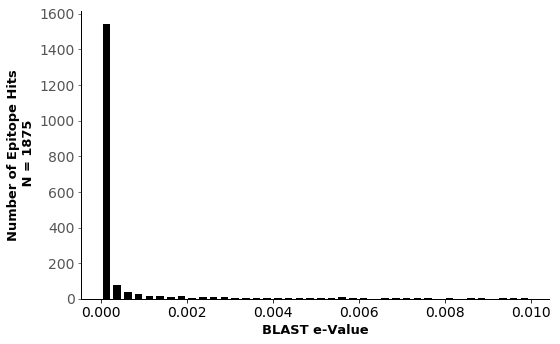

In [28]:
BLAST_p_vals = iedb_peptide_seqs.loc[: , 'BLAST exp value']
number_of_hits = len(BLAST_p_vals)

fig , ax = plt.subplots()
plt.hist(BLAST_p_vals , bins = 40 , color = 'k' , rwidth = 0.7)

plt.xlabel('BLAST e-Value', fontweight = 'bold' , fontsize = 13, color = 'k')
plt.ylabel('Number of Epitope Hits\n N = ' + str(number_of_hits), fontweight = 'bold' , fontsize = 13, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig = plt.gcf()
fig.set_size_inches(8.0, 5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/IEDB_peptide_summary_figures/IEDB_peptides_BLAST_signif_values.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 150)

plt.show()

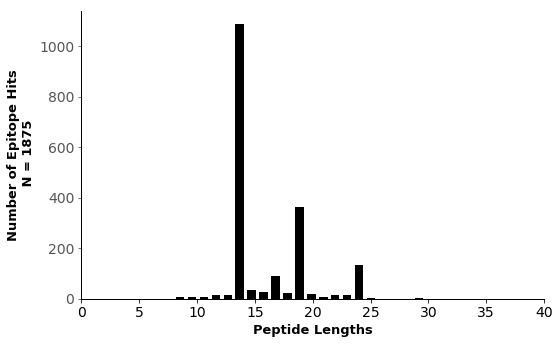

In [29]:
BLAST_hit_peptide_lengths = iedb_peptide_seqs.loc[: , 'peptide end coord from BLAST'] - iedb_peptide_seqs.loc[: , 'peptide start coord from BLAST']

fig , ax = plt.subplots()
plt.hist(BLAST_hit_peptide_lengths , bins = 30 , color = 'k' , rwidth = 0.7)

plt.xlabel('Peptide Lengths', fontweight = 'bold' , fontsize = 13, color = 'k')
plt.ylabel('Number of Epitope Hits\n N = ' + str(number_of_hits), fontweight = 'bold' , fontsize = 13, color = 'k')
plt.xlim(0 , max(BLAST_hit_peptide_lengths) + 1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig = plt.gcf()
fig.set_size_inches(8.0, 5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/IEDB_peptide_summary_figures/IEDB_peptides_lengths.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 150)

plt.show()

In [30]:
peptide_position_filter = []
for epitope_id in iedb_peptide_seqs.index:
    
    start_end_original = iedb_peptide_seqs.loc[epitope_id , ['Starting Position', 'Ending Position']]
    start_end_BLASTp = iedb_peptide_seqs.loc[epitope_id , ['peptide start coord from BLAST', 'peptide end coord from BLAST']]
    
    difference_between_coordinates = np.sum( np.abs( np.array(start_end_original) - np.array(start_end_BLASTp) ) ) 
    
    #no difference in peptide coordinates between IEDB and BLASTp results.
    if difference_between_coordinates == 0.0:
        peptide_position_filter.append(True)
        
    else:
        #homolgous proteins may be present in other parts of the genome (other than originally identified by IEDB)
        peptide_position_filter.append(True)
        
        #peptide_position_filter.append(False) #strict filter that attempts to match epitope sequences to the regions identified from IEDB
        
iedb_peptide_seqs_filtered = iedb_peptide_seqs[peptide_position_filter]

In [31]:
np.shape(iedb_peptide_seqs_filtered)

(1875, 19)

Drop unnecessary columns and re-index.

In [32]:
#change column name
iedb_peptide_seqs_filtered = iedb_peptide_seqs_filtered.rename(columns = {'Description' : 'Peptide'})

iedb_peptide_seqs_filtered_clean = iedb_peptide_seqs_filtered.loc[:, ['Peptide','H37Rv Homolog','Rv position #','start_peptide_genomic_coord','end_peptide_genomic_coord']]

#change index
iedb_peptide_seqs_filtered_clean.reset_index(inplace = True, drop = True)

In [33]:
np.shape(iedb_peptide_seqs_filtered_clean)

(1875, 5)

Number of Antigen Genes (only from most recent IEDB download)

In [34]:
antigen_genes = list(set(iedb_peptide_seqs_filtered_clean.loc[:, 'H37Rv Homolog']))
len(antigen_genes)

348

Save peptide sequences -> genomic coordinates as csv file

[saves the cleaned up dataframe that contains all of the t-cell epitope peptide sequences (and the respective genomic coordinates) from iedb]

## Final DataFrame

In [35]:
iedb_peptide_seqs_filtered_clean.head()

,Peptide,H37Rv Homolog,Rv position #,start_peptide_genomic_coord,end_peptide_genomic_coord
0,AAAAKLAGLVFPQPPAPIAV,Rv3878,14-33,39.0,99.0
1,AAAGFASKTPANQAISMIDG,Rv0934,284-303,849.0,909.0
2,AAASAIQGNVTSIHSL,Rv3875,13-28,36.0,84.0
3,AADMWGPSSDPAWER,Rv1886c,216-230,327.0,288.0
4,AAGGHNAVFNFPPNG,Rv1886c,286-300,117.0,78.0


In [36]:
iedb_peptide_seqs_filtered_clean.tail()

,Peptide,H37Rv Homolog,Rv position #,start_peptide_genomic_coord,end_peptide_genomic_coord
1870,TAGVDLAKSLRIAAK,Rv3615c,71-85,96.0,57.0
1871,TVQPERLGVLASHHD,Rv3615c,6-20,291.0,252.0
1872,TLLDVAQANLGEAAGTYV,Rv0287,67-84,198.0,252.0
1873,TLLDVAQANLGEAAGTYV,Rv3020c,67-84,90.0,42.0
1874,GKAGCQTYKWETFLTSE,Rv3804c,131-147,621.0,576.0


In [37]:
np.shape(iedb_peptide_seqs_filtered_clean)

(1875, 5)

### Export ALL peptide sequences as CSV file

In [38]:
iedb_peptide_seqs_filtered_clean.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/epitope_peptide_sequences/iedb_filtered_epitope_peptides_seqs_and_genomic_coords_05_23_18.csv' ,  sep = ',')

Read data back in from CSV file

In [39]:
epitope_peptide_seqs_genomic_coords = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/epitope_peptide_sequences/iedb_filtered_epitope_peptides_seqs_and_genomic_coords_05_23_18.csv' ,  sep = ',').set_index('Unnamed: 0')

In [40]:
epitope_peptide_seqs_genomic_coords.head()

,Peptide,H37Rv Homolog,Rv position #,start_peptide_genomic_coord,end_peptide_genomic_coord
Unnamed: 0,,,,,
0,AAAAKLAGLVFPQPPAPIAV,Rv3878,14-33,39.0,99.0
1,AAAGFASKTPANQAISMIDG,Rv0934,284-303,849.0,909.0
2,AAASAIQGNVTSIHSL,Rv3875,13-28,36.0,84.0
3,AADMWGPSSDPAWER,Rv1886c,216-230,327.0,288.0
4,AAGGHNAVFNFPPNG,Rv1886c,286-300,117.0,78.0
